<img style="float: left; height: 175px; width: 175px" src="../landlab_logo_picture.jpg"> <h3 style="margin: 117px 0 0 185px; font-weight: 300;">a toolkit for modeling earth surface processes</h3>

# Getting to know the Landlab component library

In [1]:
%matplotlib inline
#this makes figures show up correctly in this document
from landlab.components.diffusion import LinearDiffuser
from landlab import ModelParameterDictionary
from landlab.plot.imshow import imshow_node_grid
from landlab import RasterModelGrid
import numpy as np
import pylab

//anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1318: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


This ipython notebook walks you through the stages of creating and running a Landlab model using the Landlab component library.

We are going to create three models—firstly a single component driver implementing just linear diffusion; then a three-component driver implementing linear diffusion, flow routing, and stream power incision; and finally a similar model, but implementing a storm-interstorm sequence.

Let's begin with the one-component diffusion model.

Firstly, import the library elements we'll need:

Now we're going to instantiate the objects we'll need. The input file, [component_tutorial_params.txt](./component_tutorial_params.txt), in the same folder as this document, contains all the input data we need to set up the grid and initial conditions as well as the components. We're going to load those as well:

In [2]:
input_file = './component_tutorial_params.txt'
inputs = ModelParameterDictionary(input_file) #load the data into an MPD
nrows = inputs.read_int('nrows')
ncols = inputs.read_int('ncols')
dx = inputs.read_float('dx')
leftmost_elev = inputs.read_float('leftmost_elevation')
initial_slope = inputs.read_float('initial_slope') #this is zero
uplift_rate = inputs.read_float('uplift_rate')
runtime = inputs.read_float('total_time')
dt = inputs.read_float('dt')
nt = int(runtime//dt) #this is how many loops we'll need
uplift_per_step = uplift_rate * dt

...now instantiate the grid object:

In [3]:
mg = RasterModelGrid(nrows, ncols, dx) #the grid

...and put the data into the elevation field:

In [4]:
z = mg.add_zeros('node', 'topographic__elevation')

In [5]:
z += leftmost_elev

In [6]:
z += initial_slope*np.amax(mg.node_y) - initial_slope*mg.node_y

...and add a little random roughness:

In [7]:
z += np.random.rand(z.size)/100000.

Set the boundary conditions. Always do this after putting the data into the fields.

In [8]:
mg.set_closed_boundaries_at_grid_edges(False, True, False, True)

In [9]:
mg.set_fixed_value_boundaries_at_grid_edges(True, False, True, False)

Now, instantiate the component. It's also best practice to do this after both loading the data into the fields and setting the boundary conditions.

In [10]:
lin_diffuse = LinearDiffuser(mg, input_file)

Perform the loop that operates the model.

In [11]:
elapsed_time = 0.
keep_running = True
while keep_running:
    if elapsed_time+dt > runtime:
        dt = runtime-elapsed_time
        keep_running = False
    lin_diffuse.diffuse(dt) #do the diffusion
    mg.at_node['topographic__elevation'][mg.core_nodes] += uplift_per_step
    #add the uplift
    elapsed_time += dt

Now plot the output!

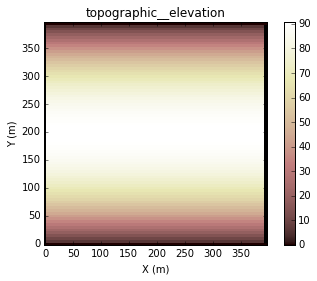

In [12]:
pylab.figure(1)
im = imshow_node_grid(mg, 'topographic__elevation', grid_units=['m','m'])

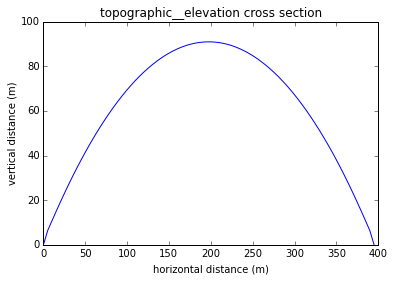

In [13]:
pylab.figure(2)
elev_rast = mg.node_vector_to_raster(mg.at_node['topographic__elevation'])
ycoord_rast = mg.node_vector_to_raster(mg.node_y)
im = pylab.plot(ycoord_rast[:,int(ncols//2)], elev_rast[:,int(ncols//2)])
pylab.xlabel('horizontal distance (m)')
pylab.ylabel('vertical distance (m)')
pylab.title('topographic__elevation cross section')

Now we're going to take a similar approach but this time combine the outputs of three distinct Landlab components: the diffuser, the monodirectional flow router, and the stream power incisor. For clarity, we're going to repeat the whole process from the start.

So first, let's import everything:

In [14]:
from landlab.components.flow_routing import FlowRouter
from landlab.components.stream_power import SPEroder
from landlab.components.diffusion import LinearDiffuser
from landlab import ModelParameterDictionary
from landlab.plot.imshow import imshow_node_grid
from landlab import RasterModelGrid
import numpy as np
import pylab

And again, get all the parameters we need to set up. Note this time we've switched units to km and artificially accelerated some rates to improve model performance, reflected in the [new input file](./coupled_params.txt).

In [15]:
input_file = './coupled_params.txt'
inputs = ModelParameterDictionary(input_file) #load the data into an MPD
nrows = inputs.read_int('nrows')
ncols = inputs.read_int('ncols')
dx = inputs.read_float('dx')
leftmost_elev = inputs.read_float('leftmost_elevation')
initial_slope = inputs.read_float('initial_slope') #this is zero
uplift_rate = inputs.read_float('uplift_rate')
runtime = inputs.read_float('total_time')
dt = inputs.read_float('dt')
nt = int(runtime//dt) #this is how many loops we'll need
uplift_per_step = uplift_rate * dt

And instantiate the grid, set the initial conditions, and set the boundary conditions:

In [16]:
mg = RasterModelGrid(nrows, ncols, dx)
z = mg.add_zeros('node', 'topographic__elevation')
z += leftmost_elev
z += initial_slope*np.amax(mg.node_y) - initial_slope*mg.node_y
initial_roughness = np.random.rand(z.size)/100000.
z += initial_roughness
mg.set_closed_boundaries_at_grid_edges(False, True, False, True)
mg.set_fixed_value_boundaries_at_grid_edges(True, False, True, False)

So far, so familiar. Now we're going to instantiate all our components:

In [17]:
fr = FlowRouter(mg) #note the flow router doesn't have to take an input file
sp = SPEroder(mg, input_file)
lin_diffuse = LinearDiffuser(mg, input_file)

And now we run! We're going to run once with the diffusion and once without.

In [18]:
elapsed_time = 0.
keep_running = True
counter = 0 #simple incremented counter to let us see the model advance
while keep_running:
    if elapsed_time+dt > runtime:
        dt = runtime-elapsed_time
        keep_running = False
    #_ = lin_diffuse.diffuse(dt) no diffusion this time
    _ = fr.route_flow() #route_flow isn't time sensitive, so it doesn't take dt as input
    _ = sp.erode(mg, dt=dt)
    #this component is of an older style,
    #so it still needs a copy of the grid to be passed
    mg.at_node['topographic__elevation'][mg.core_nodes] += uplift_per_step
    #add the uplift
    elapsed_time += dt
    if counter%50 == 0:
        print 'Completed loop ', counter
    counter += 1

ValueError: numpy.dtype has the wrong size, try recompiling

Let's see our output this time. You'll need to give the above code a few 10s of seconds to run.

In [ ]:
pylab.figure('topo without diffusion')
im = imshow_node_grid(mg, 'topographic__elevation', grid_units=['km','km'])

And now let's reset the grid elevations and do everything again, but this time, with the diffusion turned *on*:

In [ ]:
z = mg.add_zeros('node', 'topographic__elevation')
z += leftmost_elev
z += initial_slope*np.amax(mg.node_y) - initial_slope*mg.node_y
z += initial_roughness
elapsed_time = 0.
keep_running = True
dt = inputs.read_float('dt')
counter = 0
while keep_running:
    if elapsed_time+dt > runtime:
        dt = runtime-elapsed_time
        keep_running = False
    _ = lin_diffuse.diffuse(dt) #diffusion now on
    _ = fr.route_flow()
    _ = sp.erode(mg, dt=dt)
    mg.at_node['topographic__elevation'][mg.core_nodes] += uplift_per_step
    #add the uplift
    elapsed_time += dt
    if counter%50 == 0:
        print 'Completed loop ', counter
    counter += 1

In [ ]:
pylab.figure('topo with diffusion')
im = imshow_node_grid(mg, 'topographic__elevation', grid_units=['km','km'])

Beautiful! We've smoothed away the fine-scale channel roughness, as expected, and produced some lovely convex-up hillslopes in its place. Note that even though the initial conditions were identical in both cases, including the roughness, the channel positions have been moved significantly by the hillslope diffusion into the channel.

As a final step, we're going to show off some of Landlab's fancier functionality. We're going to repeat the above coupled model run, but this time we're going to plot some evolving channel profiles, and we're going to drive the simulation with a sequence of storms, not just a fixed timestep. We'll also peoduce a slope-area plot for the final conditions.

So, load the new landlab objects we'll need, then reset the initial conditions:

In [ ]:
from landlab.plot import channel_profile as prf
from landlab.components.uniform_precip import PrecipitationDistribution

In [ ]:
z = mg.add_zeros('node', 'topographic__elevation')
z += leftmost_elev
z += initial_slope*np.amax(mg.node_y) - initial_slope*mg.node_y
z += initial_roughness
dt = inputs.read_float('dt')

Instantiate the storm generator:

In [ ]:
precip = PrecipitationDistribution(input_file='coupled_params_storms.txt')

Now run:

In [ ]:
out_interval = 20.
last_trunc = runtime #we use this to trigger taking an output plot
for (interval_duration, rainfall_rate) in precip.yield_storm_interstorm_duration_intensity():
    if rainfall_rate != 0.:
        #note diffusion also only happens when it's raining...
        _ = fr.route_flow()
        sp.gear_timestep(interval_duration, rainfall_intensity_in=rainfall_rate)
        _ = sp.erode(mg)
        _ = lin_diffuse.diffuse(interval_duration)
    mg.at_node['topographic__elevation'][mg.core_nodes] += uplift_rate*interval_duration
    this_trunc = precip.elapsed_time//out_interval
    if this_trunc != last_trunc: #time to plot a new profile!
        print 'made it to time ', out_interval*this_trunc
        last_trunc=this_trunc
        pylab.figure("long_profiles")
        profile_IDs = prf.channel_nodes(mg, mg.at_node['topographic__steepest_slope'],
                        mg.at_node['drainage_area'], mg.at_node['flow_receiver'])
        dists_upstr = prf.get_distances_upstream(mg, len(mg.at_node['topographic__steepest_slope']),
                        profile_IDs, mg.at_node['links_to_flow_receiver'])
        prf.plot_profiles(dists_upstr, profile_IDs, mg.at_node['topographic__elevation'])
    #no need to track elapsed time, as the generator will stop automatically
#make the figure look nicer:
pylab.figure("long_profiles")
pylab.xlabel('Distance upstream (km)')
pylab.ylabel ('Elevation (km)')
pylab.title('Long profiles evolving through time')

Note that the "wobbles" in the long profile here are being created by the stochastic storm sequence. We could reduce their impact by reducing the storm-interstorm timescales, or allowing diffusion while it's not raining, but we've chosen not to here to show that the storms are having an effect.

In [ ]:
pylab.figure('topo with diffusion and storms')
im = imshow_node_grid(mg, 'topographic__elevation', grid_units=['km','km'])

In [ ]:
pylab.figure('final slope-area plot')
im = pylab.loglog(mg.at_node['drainage_area'], mg.at_node['topographic__steepest_slope'],'.')
pylab.xlabel('Drainage area (km**2)')
pylab.ylabel('Local slope')
pylab.title('Slope-Area plot for whole landscape')

That's a nice set of figures, eh? You can easily spend more time with pylab prettifying them if you want.